In [1]:
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
from GWO.GWO_optimizer import GWOOptimizer

In [3]:
def sphere(x):
    return torch.sum(x**2).item()

# Bounds per dimension
bounds = [(-5, 5), (0, 10), (-2, 2)]

gwo = GWOOptimizer(sphere, bounds, population_size=10, max_iter=100)
best_pos, losses = gwo.optimize()

print("Best position:", best_pos)
print("Best loss:", losses[-1])

100%|██████████| 100/100 [00:00<00:00, 6758.14it/s]

Best position: tensor([-1.4310e-09,  1.3136e-09,  1.2550e-09])
Best loss: 5.348449338323452e-18


In [11]:
n = 10000  # number of samples
r = torch.rand(n)  # random initialization
for _ in range(50):  # iterate the chaotic map
    r = 4 * r * (1 - r)

In [12]:
mean = r.mean().item()
std = r.std().item()

print(f"Mean: {mean:.4f}, Std: {std:.4f}")

Mean: 0.4969, Std: 0.3524


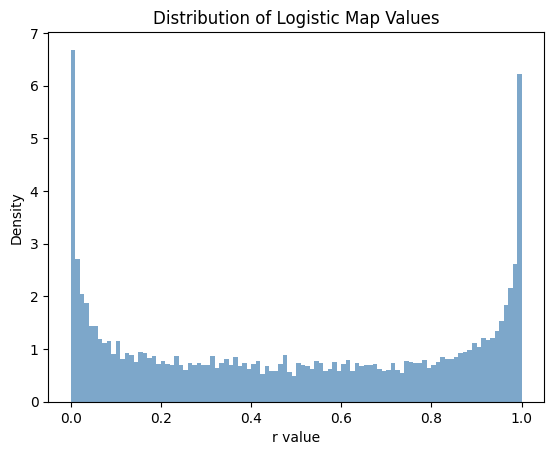

In [13]:
plt.hist(r.numpy(), bins=100, density=True, alpha=0.7, color='steelblue')
plt.title('Distribution of Logistic Map Values')
plt.xlabel('r value')
plt.ylabel('Density')
plt.show()

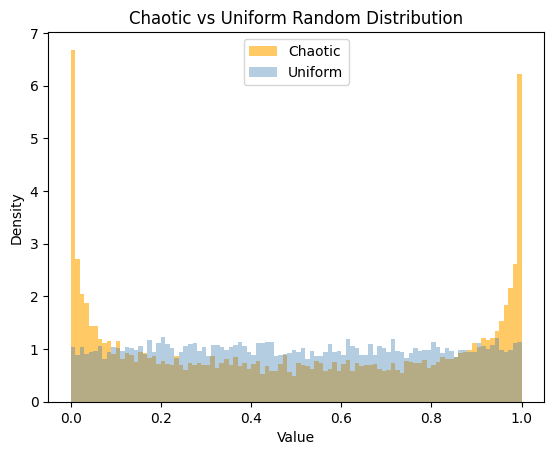

In [14]:
u = torch.rand(n)

plt.hist(r.numpy(), bins=100, density=True, alpha=0.6, label='Chaotic', color='orange')
plt.hist(u.numpy(), bins=100, density=True, alpha=0.4, label='Uniform', color='steelblue')
plt.legend()
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Chaotic vs Uniform Random Distribution')
plt.show()
